In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import joblib
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, Dropout

In [41]:
#@title Data Load
def load_data(train_path, test_path):
    """Memuat dataset dari path yang diberikan."""
    print("\n--- [1] Loading Data ---")
    print(f"Train path: {train_path}")
    print(f"Test path : {test_path}")

    if not os.path.exists(train_path) or not os.path.exists(test_path):
        print(f"\n[ERROR] File tidak ditemukan!")
        print("Jika di Google Colab, pastikan Drive sudah di-mount.")
        print("Jika di Lokal, pastikan file ada di folder 'data/'.")
        sys.exit()

    try:
        df_train = pd.read_csv(train_path, sep='\t', on_bad_lines='skip')
        df_test = pd.read_csv(test_path, sep='\t', on_bad_lines='skip')
        print(f"Sukses memuat data. Train shape: {df_train.shape}, Test shape: {df_test.shape}")
        return df_train, df_test
    except Exception as e:
        print(f"[ERROR] Gagal membaca file: {e}")
        sys.exit()

def preprocess_data(df_train, df_test):
    """Membersihkan teks dan mengubah label target menjadi angka."""
    print("\n--- [2] Preprocessing Data ---")

    # Gabungkan kolom teks
    text_cols = ['benefitsReview', 'sideEffectsReview', 'commentsReview']
    for col in text_cols:
        df_train[col] = df_train[col].fillna('')
        df_test[col] = df_test[col].fillna('')

    df_train['text'] = df_train['benefitsReview'] + " " + df_train['sideEffectsReview'] + " " + df_train['commentsReview']
    df_test['text'] = df_test['benefitsReview'] + " " + df_test['sideEffectsReview'] + " " + df_test['commentsReview']

    # Encode target 'effectiveness'
    le = LabelEncoder()
    y_train = le.fit_transform(df_train['effectiveness'])
    try:
        y_test = le.transform(df_test['effectiveness'])
    except ValueError:
        print("Warning: Label baru ditemukan di test set. Refitting encoder...")
        le.fit(pd.concat([df_train['effectiveness'], df_test['effectiveness']]))
        y_train = le.transform(df_train['effectiveness'])
        y_test = le.transform(df_test['effectiveness'])

    print(f"Classes encoded: {list(le.classes_)}")
    return df_train['text'], y_train, df_test['text'], y_test, list(le.classes_), le

In [42]:
#@title Feature
def get_tfidf_features(train_text, test_text):
    """TF-IDF untuk Machine Learning konvensional."""
    print("\n--- [3A] Feature Engineering: TF-IDF ---")
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train = tfidf.fit_transform(train_text)
    X_test = tfidf.transform(test_text)
    print(f"TF-IDF Shape: {X_train.shape}")
    return X_train, X_test, tfidf

def get_sequence_features(train_text, test_text, vocab_size=10000, max_len=200):
    """Tokenization & Padding untuk Deep Learning."""
    print("\n--- [3B] Feature Engineering: Tokenization ---")
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_text)

    train_seq = tokenizer.texts_to_sequences(train_text)
    test_seq = tokenizer.texts_to_sequences(test_text)

    X_train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_pad = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')
    print(f"Sequence Shape: {X_train_pad.shape}")
    return X_train_pad, X_test_pad

In [43]:
#@title Modeling Training
def train_models(X_train_tfidf, X_test_tfidf, X_train_seq, X_test_seq, y_train, y_test, classes, vocab_size, max_len):
    """Melatih 3 model dan mengembalikan objek model serta hasil evaluasi."""
    model_scores = {}

    # --- Model 1: Baseline ---
    print("\n=== Model 1: Baseline (Dummy) ===")
    base_model = DummyClassifier(strategy='most_frequent')
    base_model.fit(X_train_tfidf, y_train)
    y_pred_base = base_model.predict(X_test_tfidf)
    acc_base = accuracy_score(y_test, y_pred_base)
    model_scores['Baseline'] = acc_base
    print(classification_report(y_test, y_pred_base, target_names=classes, zero_division=0))

    # --- Model 2: Random Forest ---
    print("\n=== Model 2: Random Forest ===")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_tfidf, y_train)
    y_pred_rf = rf_model.predict(X_test_tfidf)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    model_scores['Random Forest'] = acc_rf
    print(classification_report(y_test, y_pred_rf, target_names=classes, zero_division=0))

    # --- Model 3: Deep Learning ---
    print("\n=== Model 3: Deep Learning (TensorFlow) ===")
    num_classes = len(classes)

    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(input_dim=vocab_size, output_dim=16),
        GlobalAveragePooling1D(),
        Dense(24, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(
        X_train_seq, y_train,
        epochs=15,
        validation_data=(X_test_seq, y_test),
        verbose=1
    )

    # Evaluasi DL
    print("\n>>> Evaluasi Akhir Deep Learning:")
    y_pred_probs = model.predict(X_test_seq)
    y_pred_dl = np.argmax(y_pred_probs, axis=1)
    acc_dl = accuracy_score(y_test, y_pred_dl)
    model_scores['Deep Learning'] = acc_dl
    print(classification_report(y_test, y_pred_dl, target_names=classes, zero_division=0))

    return history, model_scores, base_model, rf_model, model

In [44]:
#@title Ploting
def plot_class_distribution(y_train, classes, output_file='distribusi_kelas.png'):
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(y_train, return_counts=True)
    class_labels = [classes[i] for i in unique]
    sns.barplot(x=class_labels, y=counts, palette='viridis')
    plt.title('Visualisasi 1: Distribusi Kelas Target (Effectiveness)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Grafik distribusi disimpan di: {output_file}")

def plot_correlation_heatmap(tfidf_matrix, feature_names, output_file='heatmap_korelasi.png'):
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[-30:][::-1]
    top_features_data = tfidf_matrix[:, top_indices].toarray()
    top_feature_names = [feature_names[i] for i in top_indices]
    df_subset = pd.DataFrame(top_features_data, columns=top_feature_names)
    corr_matrix = df_subset.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
    plt.title('Visualisasi 2: Heatmap Korelasi (30 Fitur Teratas)')
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Grafik heatmap disimpan di: {output_file}")

def plot_model_comparison(scores, output_file='perbandingan_model.png'):
    plt.figure(figsize=(8, 5))
    models = list(scores.keys())
    accuracies = list(scores.values())
    bars = plt.bar(models, accuracies, color=['gray', 'blue', 'green'])
    plt.ylim(0, 1.0)
    plt.title('Visualisasi 3: Perbandingan Akurasi Model')
    plt.ylabel('Akurasi')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Grafik perbandingan model disimpan di: {output_file}")

def plot_training_history(history, output_file='training_history.png'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Deep Learning Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Deep Learning Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Grafik training history disimpan di: {output_file}")

def plot_wordcloud(text_data, output_file='wordcloud.png'):
    """Visualisasi WordCloud dari seluruh teks ulasan"""
    all_text = " ".join(text_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=200, colormap='viridis').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Visualisasi: WordCloud Kata yang Sering Muncul')
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Grafik WordCloud disimpan di: {output_file}")

In [45]:
def save_artifacts(rf_model, dl_model, vectorizer, output_dir='models'):
    """Menyimpan model Random Forest (pkl) dan Deep Learning (keras) serta Vectorizer."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Simpan Model Machine Learning (Random Forest) sebagai .pkl
    rf_path = os.path.join(output_dir, 'model_rf.pkl')
    joblib.dump(rf_model, rf_path)
    print(f"\n[SAVED] Random Forest model disimpan di: {rf_path}")

    # 2. Simpan TF-IDF Vectorizer (Penting untuk prediksi data baru!)
    vec_path = os.path.join(output_dir, 'tfidf_vectorizer.pkl')
    joblib.dump(vectorizer, vec_path)
    print(f"[SAVED] TF-IDF Vectorizer disimpan di: {vec_path}")

    # 3. Simpan Deep Learning Model (.h5 / .keras)
    # Pickle kurang cocok untuk Keras, gunakan format bawaan Keras
    dl_path = os.path.join(output_dir, 'model_dl.keras')
    dl_model.save(dl_path)
    print(f"[SAVED] Deep Learning model disimpan di: {dl_path}")


--- [1] Loading Data ---
Train path: /content/drive/MyDrive/Data Science/drug+review+dataset+druglib+com/drugLibTrain_raw.tsv
Test path : /content/drive/MyDrive/Data Science/drug+review+dataset+druglib+com/drugLibTest_raw.tsv
Sukses memuat data. Train shape: (3107, 9), Test shape: (1036, 9)

--- [2] Preprocessing Data ---
Classes encoded: ['Considerably Effective', 'Highly Effective', 'Ineffective', 'Marginally Effective', 'Moderately Effective']


/tmp/ipython-input-1082493841.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=counts, palette='viridis')


Grafik distribusi disimpan di: /content/drive/MyDrive/Data Science/models/distribusi_kelas.png
Grafik WordCloud disimpan di: /content/drive/MyDrive/Data Science/models/wordcloud.png

--- [3A] Feature Engineering: TF-IDF ---
TF-IDF Shape: (3107, 5000)
Grafik heatmap disimpan di: /content/drive/MyDrive/Data Science/models/heatmap_korelasi.png

--- [3B] Feature Engineering: Tokenization ---
Sequence Shape: (3107, 200)

=== Model 1: Baseline (Dummy) ===
                        precision    recall  f1-score   support

Considerably Effective       0.00      0.00      0.00       310
      Highly Effective       0.40      1.00      0.57       411
           Ineffective       0.00      0.00      0.00        82
  Marginally Effective       0.00      0.00      0.00        76
  Moderately Effective       0.00      0.00      0.00       157

              accuracy                           0.40      1036
             macro avg       0.08      0.20      0.11      1036
          weighted avg       0.1

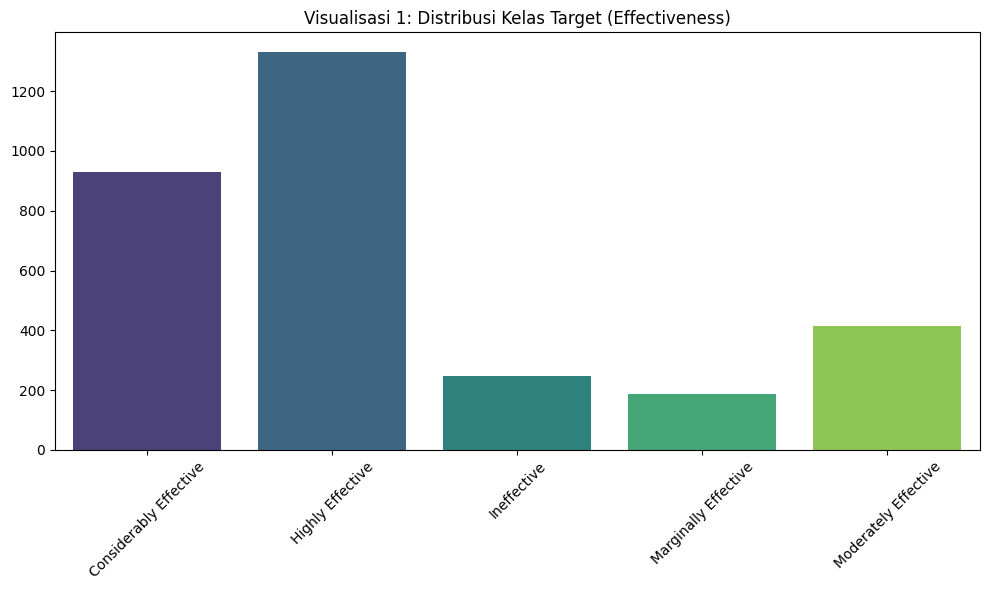

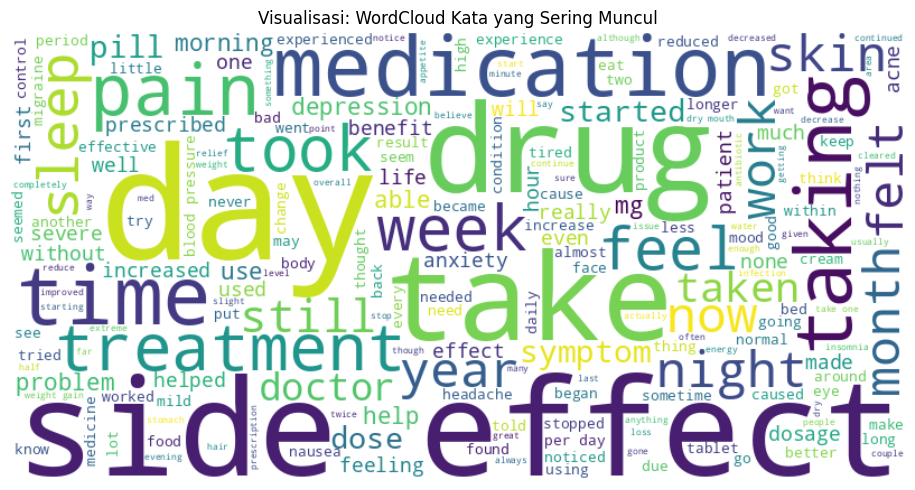

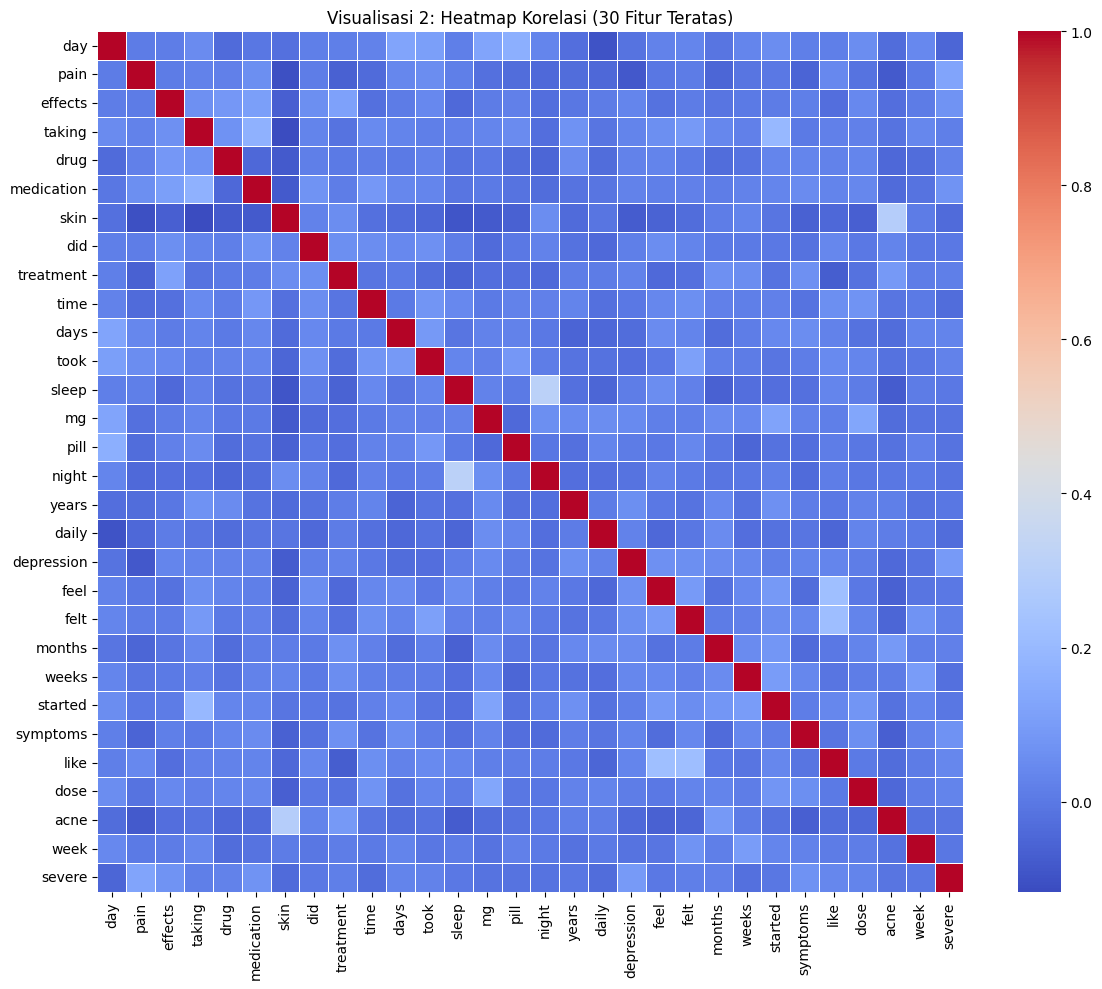

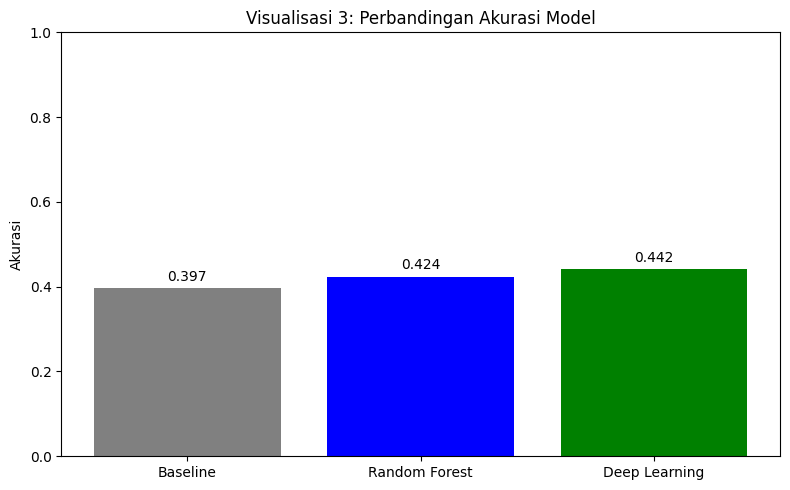

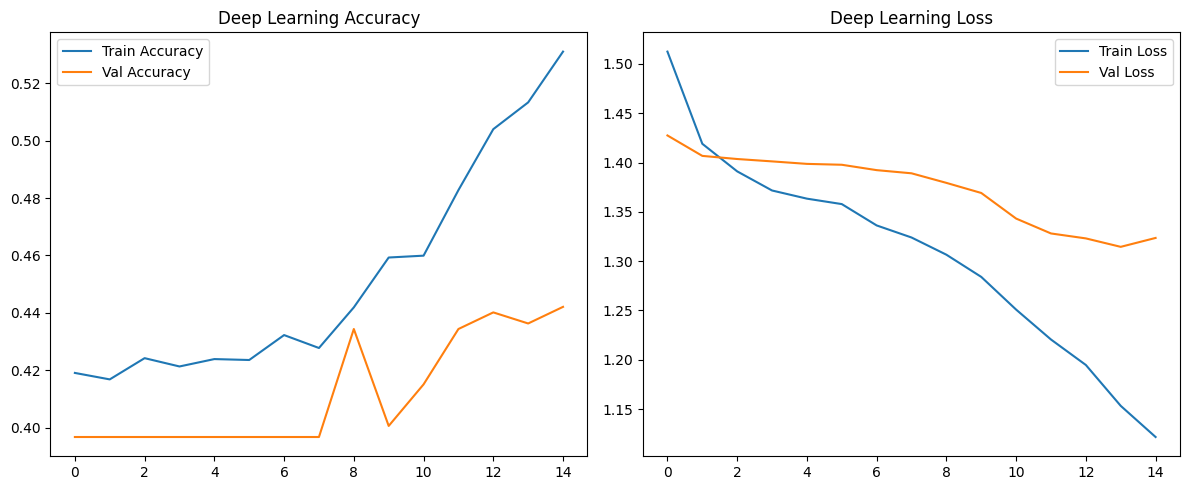

In [46]:
#@title Execution
if __name__ == "__main__":
    # --- PENGATURAN PATH ---
    COLAB_TRAIN = '/content/drive/MyDrive/Data Science/drug+review+dataset+druglib+com/drugLibTrain_raw.tsv'
    COLAB_TEST = '/content/drive/MyDrive/Data Science/drug+review+dataset+druglib+com/drugLibTest_raw.tsv'

    if os.path.exists(COLAB_TRAIN):
        train_path, test_path = COLAB_TRAIN, COLAB_TEST
        base_dir = '/content/drive/MyDrive/Data Science/models/'
        if not os.path.exists(base_dir): os.makedirs(base_dir)
    else:
        base_dir = os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(base_dir, '..', 'data')
        train_path = os.path.join(data_dir, 'drugLibTrain_raw.tsv')
        test_path = os.path.join(data_dir, 'drugLibTest_raw.tsv')

        if not os.path.exists(train_path):
             train_path = 'drugLibTrain_raw.tsv'
             test_path = 'drugLibTest_raw.tsv'

        base_dir = '.'

    # 1. Load Data
    df_train, df_test = load_data(train_path, test_path)

    # 2. Preprocessing
    X_train_text, y_train, X_test_text, y_test, classes, le = preprocess_data(df_train, df_test)

    # Visualisasi 1 & WordCloud
    plot_class_distribution(y_train, classes, output_file=os.path.join(base_dir, 'distribusi_kelas.png'))
    plot_wordcloud(X_train_text, output_file=os.path.join(base_dir, 'wordcloud.png'))

    # 3. Feature Engineering
    # TF-IDF
    X_train_tfidf, X_test_tfidf, tfidf_vectorizer = get_tfidf_features(X_train_text, X_test_text)
    plot_correlation_heatmap(X_train_tfidf, tfidf_vectorizer.get_feature_names_out(), output_file=os.path.join(base_dir, 'heatmap_korelasi.png'))

    # Sequences (DL)
    X_train_seq, X_test_seq = get_sequence_features(X_train_text, X_test_text)

    # 4. Training
    # Perhatikan: fungsi ini sekarang mengembalikan 3 model juga
    history, scores, base_model, rf_model, dl_model = train_models(
        X_train_tfidf, X_test_tfidf, X_train_seq, X_test_seq,
        y_train, y_test, classes, vocab_size=10000, max_len=200
    )

    # Visualisasi Hasil Model
    plot_model_comparison(scores, output_file=os.path.join(base_dir, 'perbandingan_model.png'))
    plot_training_history(history, output_file=os.path.join(base_dir, 'training_history.png'))

    # 5. Saving Artifacts (Model & Vectorizer)
    save_artifacts(rf_model, dl_model, tfidf_vectorizer, output_dir=base_dir)

    print("\n--- Selesai! Semua grafik dan model telah disimpan. ---")